In [ ]:
%%capture
!pip install pytorch-lightning

In [ ]:
import os
from glob import glob
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar, EarlyStopping

from torchmetrics import Accuracy, F1Score, MetricCollection

### PyTorch Lightning Model V1

In [ ]:
class CIFARModel(pl.LightningModule):

    def __init__(self):
        super(CIFARModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.metrics = MetricCollection([
            Accuracy(task='multiclass', num_classes=10),
            F1Score(task='multiclass', num_classes=10, average='weighted'),
        ])

        self.val_metrics = self.metrics.clone(prefix='val_')
        self.test_metrics = self.metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.val_metrics.update(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.log_dict(self.val_metrics.compute(), prog_bar=True, on_epoch=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        self.test_metrics.update(logits, y)

    def on_test_epoch_end(self) -> None:
        self.log_dict(self.test_metrics.compute(), prog_bar=True, on_epoch=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer=optimizer,
            step_size=2,
            gamma=0.5,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }
        return [optimizer], [lr_scheduler]

In [ ]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 128):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage: str):
        if stage == "fit":
              data_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
              trainset, self.valset = random_split(data_full, [40000, 10000])
              train_indices = torch.randperm(len(trainset))[:10000]
              self.trainset = Subset(trainset, train_indices)

        if stage == "test":
            #self.testset = CIFAR10(self.data_dir, train=False, transform=self.transform)
            self.testset = CIFAR10(
                root=self.data_dir,
                train=False,
                download=True,
                transform=self.transform,
            )

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size)

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [ ]:
datamodule = CIFAR10DataModule()
cnn_model = CIFARModel()

In [ ]:
trainer = pl.Trainer(
    max_epochs=25,
    log_every_n_steps=10,
    callbacks=[TQDMProgressBar(refresh_rate=10), EarlyStopping(monitor="val_loss", mode="min", patience=3)],
)
trainer.fit(model=cnn_model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | conv1        | Conv2d           | 456    | train
1 | pool         | MaxPool2d        | 0      | train
2 | conv2        | Conv2d           | 2.4 K  | train
3 | fc1          | Linear           | 48.1 K | train
4 | fc2          | Linear           | 10.2 K | train
5 | fc3          | Linear           | 850    | train
6 | metrics      | MetricCollection | 0      | train
7 | val_metrics  | MetricCollection | 0      | train
8 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(datamodule=datamodule)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=8-step=711.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=8-step=711.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.48410001397132874    │
│  test_MulticlassF1Score   │    0.48117175698280334    │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.48410001397132874,
  'test_MulticlassF1Score': 0.48117175698280334}]

### Batch Normalization в сверточных слоях

Сверточный слой можно свести к линейному слою. Batch Normalization можно применять и для линейных слоев, и для сверточных.

Признаки внутри одного канала (одной карты признаков) получаются путем применения к исходному изображению одних и тех же преобразований. По сути **1 канал** — это **карта одного признака**. Поэтому логично, что нормализация будет происходить по каналам, а одним признаком считается одна feature map - один выходной канал.
Нормализация идет по всей такой feature map (по всему каналу) для всех объектов батча.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/feature_map.png" width="500"></center>

В PyTorch для полносвязных слоев используют [nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), а для сверточных — [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

Графически нормализации часто объясняют при помощи следующей схемы:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dimensions_channels_batch_samples.png" width="450"></center>

*По оси абсцисс* расположены **объекты из батча**,
*по оси ординат* &mdash; **содержимое feature map**, преобразованное в вектор,
*по оси аппликат* &mdash; **каналы** (feature maps).

Размер такого кубика:
$$[\text{batch size}, \text{channels}, \text{h} * \text{w}]$$

В этом представлении **Batch Norm** для свертки выглядит следующим образом:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/visualization_of_batch_normalization.png" width="450">


Статистики считаются по срезу:

$$[\text{:}, \text{ channels}, \text{ :}, \text{ :}]$$

Всего считается $\text{channels}$ статистик, по одной для каждой карты признаков.

[Иллюстрация вычислений BatchNorm2d](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ITU034_CFazKREbzgAiExg.png)

### Dropout в сверточных слоях

Аналогично Batch Normalization, при применении к сверточному слою  Dropout должен **убирать каналы целиком**. Dropout для полносвязного слоя реализован в PyTorch в [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), для сверточного — в [nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)

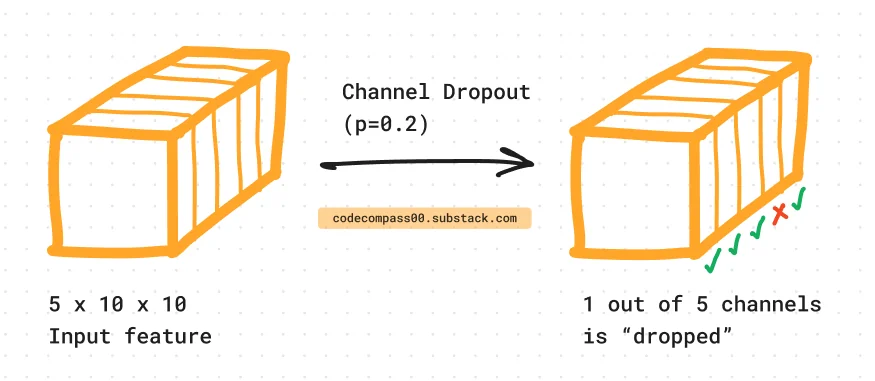

### PyTorch Lightning Model V2

In [ ]:
class CIFARModelV2(pl.LightningModule):
    def __init__(self):
        super(CIFARModelV2, self).__init__()
        self.model = nn.Sequential(
          nn.Conv2d(3, 6, 5),
          nn.BatchNorm2d(6),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout2d(0.1),

          nn.Conv2d(6, 16, 5),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout2d(0.1),

          nn.Flatten(),
          nn.Linear(16 * 5 * 5, 120),
          nn.Dropout(0.1),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.Dropout(0.1),
          nn.ReLU(),
          nn.Linear(84, 10)
        )

        self.metrics = MetricCollection([
            Accuracy(task='multiclass', num_classes=10),
            F1Score(task='multiclass', num_classes=10, average='weighted'),
        ])

        self.val_metrics = self.metrics.clone(prefix='val_')
        self.test_metrics = self.metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.cross_entropy(logits, y)
        self.val_metrics.update(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self) -> None:
        self.log_dict(self.val_metrics.compute(), prog_bar=True, on_epoch=True)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        self.test_metrics.update(logits, y)

    def on_test_epoch_end(self) -> None:
        self.log_dict(self.test_metrics.compute(), prog_bar=True, on_epoch=True)
        self.test_metrics.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer=optimizer,
            step_size=2,
            gamma=0.5,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "val_loss",
        }
        return [optimizer], [lr_scheduler]

In [ ]:
datamodule = CIFAR10DataModule()
cnn_model = CIFARModelV2()

In [ ]:
trainer = pl.Trainer(
    max_epochs=25,
    log_every_n_steps=10,
    fast_dev_run=False,
    callbacks=[TQDMProgressBar(refresh_rate=10), EarlyStopping(monitor="val_loss", mode="min", patience=3)],
)
trainer.fit(model=cnn_model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | Sequential       | 62.1 K | train
1 | metrics      | MetricCollection | 0      | train
2 | val_metrics  | MetricCollection | 0      | train
3 | test_metrics | MetricCollection | 0      | train
----------------------------------------------------------
62.1 K    Trainable params
0         Non-trainable params
62.1 K    Total params
0.248     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=23-step=1896.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=23-step=1896.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.4896000027656555     │
│  test_MulticlassF1Score   │    0.4846656322479248     │
└───────────────────────────┴───────────────────────────┘

[{'test_MulticlassAccuracy': 0.4896000027656555,
  'test_MulticlassF1Score': 0.4846656322479248}]